In [1]:
import os
import torch
from torch import nn
import pandas as pd

#custom packages
import dataloaders
import helpers
import shared_models
import features

import warnings
warnings.filterwarnings('always') 

/Users/claireboyd/courses/advanced_ml/dirty_comments_and_clean_plates/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ONLY RUN THIS ONCE
os.chdir("..")
os.path.abspath(os.curdir)

'/Users/claireboyd/courses/advanced_ml/dirty_comments_and_clean_plates'

#### Create DataLoaders
Use classes and functions stored in dataloaders.py to create custom dataloaders.

In [8]:
#input data sources
train_fp = "data/phila/split/train.csv"
test_fp = "data/phila/split/test.csv"
val_fp = "data/phila/split/val.csv"

#parameters
FEATURES = features.FEATURES.extend(features.CATEGORIES)
MAX_FEATURES = 2000
NGRAM_RANGE = (1,2)
TRAIN_BATCH_SIZE = 16
VAL_TEST_BATCH_SIZE = 8

INPUT_DIM = 2000
OUTPUT_DIM = 2
EPOCHS = 300
LR = 1e-05

In [6]:
#build vectorizer
train_vectorizer = dataloaders.Vectorizer(
    max_features=MAX_FEATURES,
    ngram_range=NGRAM_RANGE, 
    stop_words="english"
)

#build datasets
train_dataset = dataloaders.ReviewsDataset(
    vectorizer=train_vectorizer,
    df_filepath=train_fp,
    features=FEATURES
)
val_dataset = dataloaders.ReviewsDataset(
    vectorizer=train_vectorizer,
    df_filepath=val_fp,
    features=FEATURES
)
test_dataset = dataloaders.ReviewsDataset(
    vectorizer=train_vectorizer,
    df_filepath=test_fp,
    features=FEATURES
)

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=VAL_TEST_BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=VAL_TEST_BATCH_SIZE, shuffle=True)

# train_dataset_exploded = model_framework.ReviewsDataset(
#     vectorizer=train_vectorizer,
#     df_filepath=train_fp,
#     features=FEATURES,
#     expanded=True
# )
# val_dataset_exploded = model_framework.ReviewsDataset(
#     vectorizer=train_vectorizer,
#     df_filepath=val_fp,
#     features=FEATURES,
#     expanded=True
# )
# test_dataset_exploded = model_framework.ReviewsDataset(
#     vectorizer=train_vectorizer,
#     df_filepath=test_fp,
#     features=FEATURES,
#     expanded=True
# )

#### Logistic Regression

In [9]:
#model & optimizer
log_regr_model = shared_models.LogisticRegression(INPUT_DIM, OUTPUT_DIM)
optimizer = torch.optim.SGD(log_regr_model.parameters(), lr=LR)
loss_function = nn.CrossEntropyLoss()

#run
log_regr_model_val_metrics = helpers.train_model(log_regr_model, train_dataloader, val_dataloader, optimizer, loss_function, EPOCHS)

At epoch 0: loss = 0.695, and accuracy = 0.361
At epoch 100: loss = 0.694, and accuracy = 0.528
At epoch 200: loss = 0.693, and accuracy = 0.644


Final values: f1 0.033, accuracy 0.731, recall 0.018


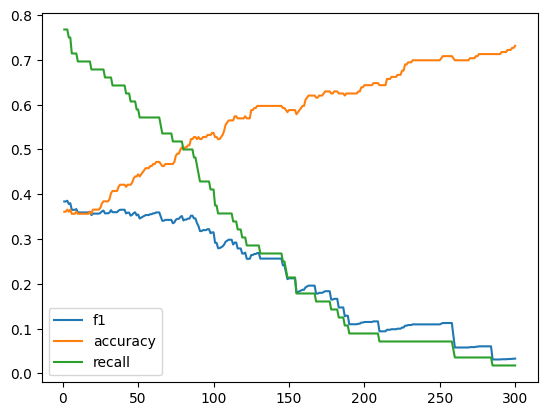

In [10]:
helpers.plot_metrics(log_regr_model_val_metrics)

#### Logistic Regression with Features

In [13]:
log_regr_model = shared_models.LogisticRegressionwithFeatures(INPUT_DIM, len(FEATURES), OUTPUT_DIM)
optimizer = torch.optim.SGD(log_regr_model.parameters(), lr=LR)
loss_function = nn.NLLLoss()

log_regr_val_accuracies_with_features = helpers.train_model(log_regr_model, train_dataloader, val_dataloader, optimizer, loss_function, EPOCHS, include_features=True)

At epoch 0: loss = -0.366, and accuracy = 0.259
At epoch 100: loss = -0.889, and accuracy = 0.380
At epoch 200: loss = -0.942, and accuracy = 0.731


Final values: f1 0.000, accuracy 0.741, recall 0.000


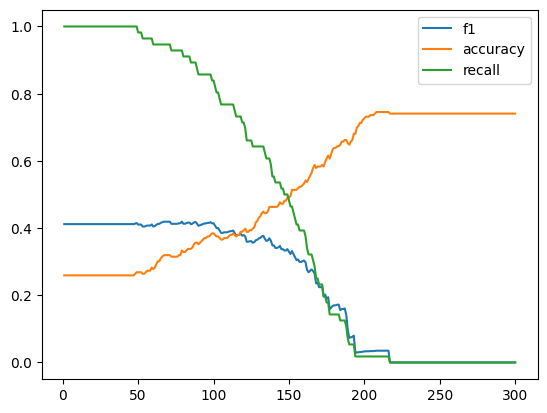

In [14]:
helpers.plot_metrics(log_regr_val_accuracies_with_features)

#### Support Vector Machine (SVM)

In [11]:
svm_model = shared_models.SVM(INPUT_DIM)
optimizer = torch.optim.SGD(svm_model.parameters(), lr=LR, weight_decay=0.01)
loss_function = nn.MultiMarginLoss()

swm_val_accuracies = helpers.train_model(svm_model, train_dataloader, val_dataloader, optimizer, loss_function, EPOCHS)

At epoch 0: loss = 0.496, and accuracy = 0.685
At epoch 100: loss = 0.456, and accuracy = 0.741
At epoch 200: loss = 0.416, and accuracy = 0.741


Final values: f1 0.000, accuracy 0.741, recall 0.000


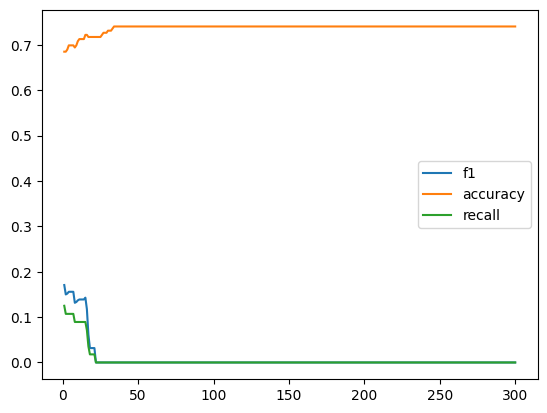

In [12]:
helpers.plot_metrics(swm_val_accuracies)